## Submit

## Импорт модулей и датасета

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder, PolynomialEncoder
from category_encoders.glmm import GLMMEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()
from datetime import timedelta
import datetime as dt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.random.seed(42)
%config InlineBackend.figure_format = 'retina'

# sns.set(style='whitegrid', palette='deep')
# sns.set(style='darkgrid', palette='rocket')
sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

In [2]:
target = 'source_attractiveness'
df_orig = pd.read_csv('../input/mai-ml-lab-1-biro/train.csv', index_col=0)
df = df_orig.copy()
df.head()

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
6622,ecom,6488536.00000,NaN,0,82221,0,0,18.45053,0.46175,2020-04-21 16:04:41.817367072
2047,information_source,874840.00000,21100.00000,0,12872,0,0,10.72162,-0.02232,2024-07-19 23:50:07.268931816
1118,information_source,571210.00000,94707.00000,0,0,7420,0,1.92224,0.04640,2024-07-13 16:35:54.794883135
4992,news,89534.00000,924.00000,0,834,0,0,2.14924,-0.09336,2024-09-10 21:29:14.006315095
9970,information_source,1043953.00000,289288.00000,0,58375,20260,3948,3.76497,0.02730,2024-05-26 11:07:15.950527838


## Анализ

In [3]:
df.head()

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
6622,ecom,6488536.00000,NaN,0,82221,0,0,18.45053,0.46175,2020-04-21 16:04:41.817367072
2047,information_source,874840.00000,21100.00000,0,12872,0,0,10.72162,-0.02232,2024-07-19 23:50:07.268931816
1118,information_source,571210.00000,94707.00000,0,0,7420,0,1.92224,0.04640,2024-07-13 16:35:54.794883135
4992,news,89534.00000,924.00000,0,834,0,0,2.14924,-0.09336,2024-09-10 21:29:14.006315095
9970,information_source,1043953.00000,289288.00000,0,58375,20260,3948,3.76497,0.02730,2024-05-26 11:07:15.950527838


<Axes: >

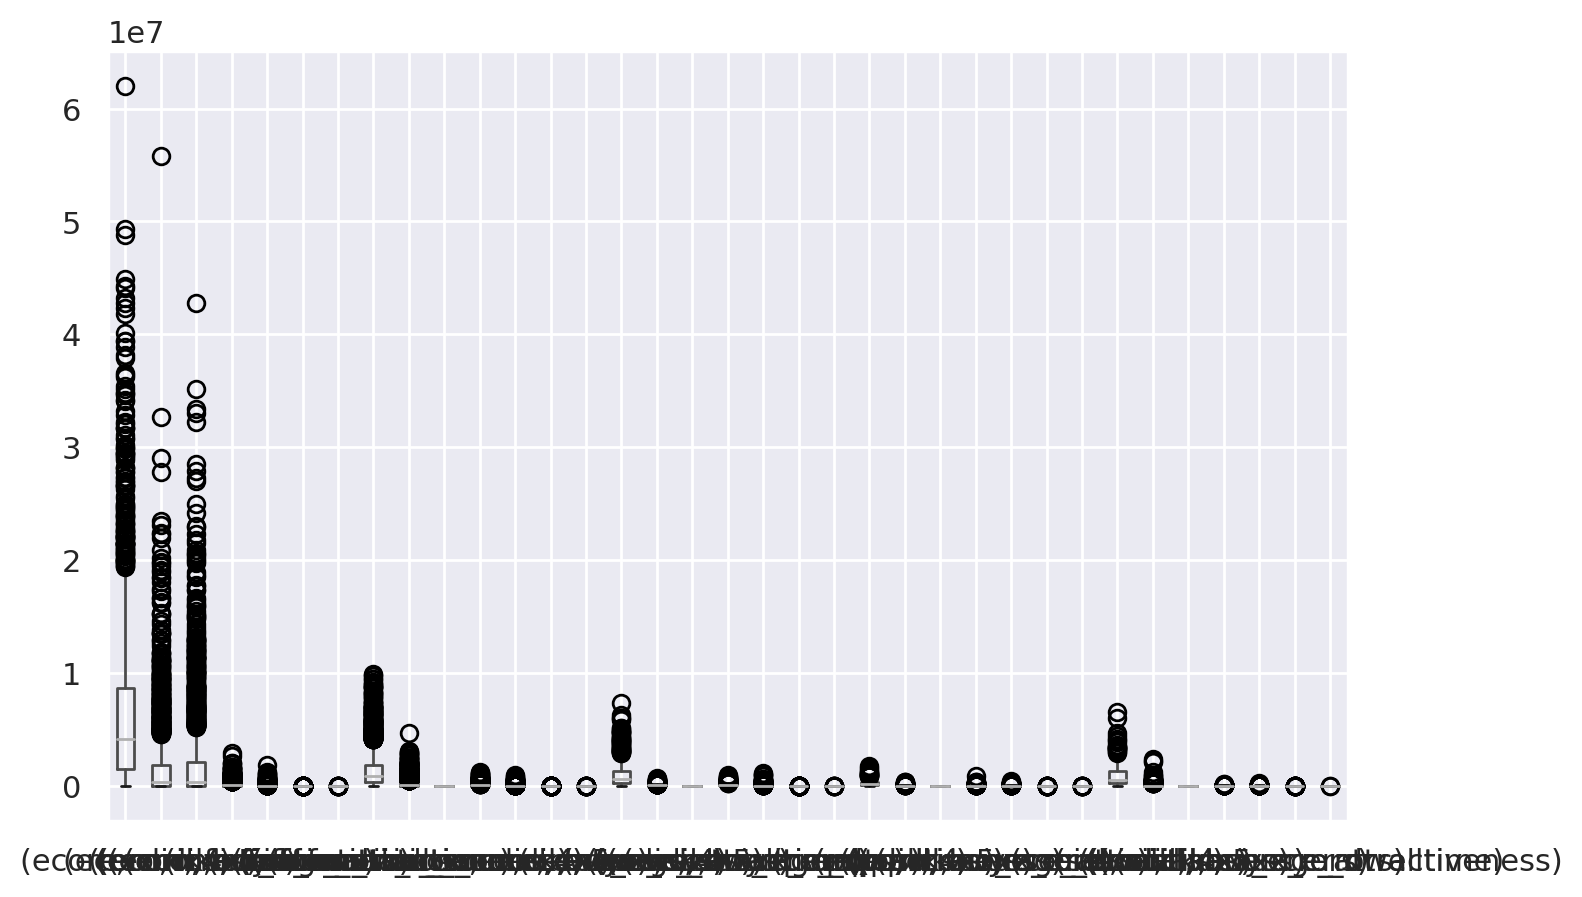

In [4]:
df.groupby('category').boxplot('source_attractiveness')

In [5]:
df.drop_duplicates().shape == df.shape

True

[Text(0.5, 0, 'source_attractiveness'), Text(0, 0.5, 'count')]

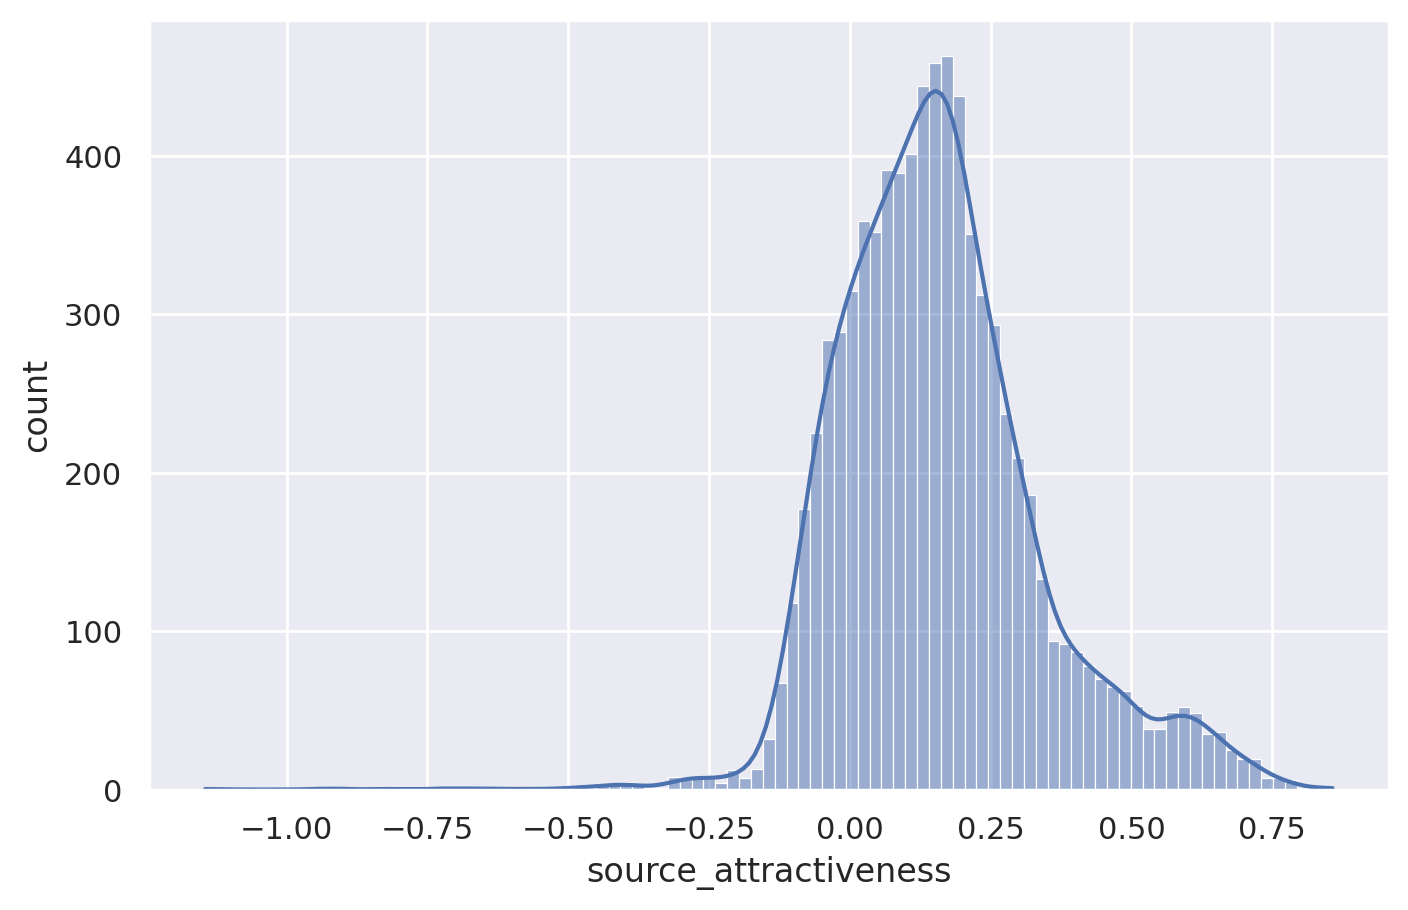

In [6]:
plot = sns.histplot(np.log1p(df[target].values), kde=True)
plot.set(xlabel=target, ylabel='count')

In [7]:
df.dtypes

category                  object
clicks                   float64
likes                    float64
buys                       int64
4xx_errors                 int64
5xx_errors                 int64
complaints_count          object
average_dwelltime        float64
source_attractiveness    float64
date_of_registration      object
dtype: object

In [8]:
df.category.unique()

array(['ecom', 'information_source', 'news', 'porn', 'social'],
      dtype=object)

In [9]:
sum(df.category.isna())

0

In [10]:
df.describe()

,clicks,likes,buys,4xx_errors,5xx_errors,average_dwelltime,source_attractiveness
count,7727.00000,7624.00000,8000.00000,8000.00000,8000.00000,8000.00000,8000.00000
mean,2749784.60826,598502.74318,581050.94688,82049.57962,27692.24125,6.97955,0.19200
std,4699119.93978,1978345.31783,2262221.35719,155521.90818,79469.34824,10.00492,0.22787
min,51.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,-0.68172
25%,359921.00000,0.00000,0.00000,2943.00000,0.00000,1.50393,0.03822
50%,1097221.00000,33995.50000,0.00000,26717.50000,0.00000,4.02280,0.15426
75%,2915358.00000,286063.75000,0.00000,95002.25000,20163.75000,8.89940,0.28251
max,62032065.00000,55821812.00000,42773913.00000,2904996.00000,1865588.00000,211.21807,1.35574


In [11]:
dataset = df.copy()
dataset.complaints_count = dataset.complaints_count.replace('-', np.NAN)
dataset.average_dwelltime = dataset.average_dwelltime.replace(-1, np.NAN)
dataset = dataset.dropna()

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6229 entries, 2047 to 1231
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   category               6229 non-null   object 
 1   clicks                 6229 non-null   float64
 2   likes                  6229 non-null   float64
 3   buys                   6229 non-null   int64  
 4   4xx_errors             6229 non-null   int64  
 5   5xx_errors             6229 non-null   int64  
 6   complaints_count       6229 non-null   object 
 7   average_dwelltime      6229 non-null   float64
 8   source_attractiveness  6229 non-null   float64
 9   date_of_registration   6229 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 535.3+ KB


In [13]:
dataset.complaints_count = dataset.complaints_count.astype(dtype="Int64")
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.05)
        Q3 = df[column].quantile(0.95)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

numeric_columns = dataset.select_dtypes(include=[np.number]).columns
dataset_cleaned = remove_outliers(dataset, numeric_columns)
dataset_cleaned

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
2047,information_source,874840.00000,21100.00000,0,12872,0,0,10.72162,-0.02232,2024-07-19 23:50:07.268931816
1118,information_source,571210.00000,94707.00000,0,0,7420,0,1.92224,0.04640,2024-07-13 16:35:54.794883135
4992,news,89534.00000,924.00000,0,834,0,0,2.14924,-0.09336,2024-09-10 21:29:14.006315095
9970,information_source,1043953.00000,289288.00000,0,58375,20260,3948,3.76497,0.02730,2024-05-26 11:07:15.950527838
4553,porn,99712.00000,0.00000,0,0,15178,3725,20.78693,0.06357,2023-04-26 05:40:15.012475568
...,...,...,...,...,...,...,...,...,...,...
5931,information_source,4221099.00000,1204744.00000,0,336212,24270,8234,0.45192,0.11576,2023-11-26 01:52:45.125399716
361,information_source,1468601.00000,474524.00000,0,61307,83928,16841,4.19148,0.01747,2023-06-20 19:48:01.783634440
2621,information_source,93172.00000,6418.00000,0,3418,705,0,3.74519,-0.01907,2024-07-22 08:45:41.700070757
2605,information_source,82916.00000,0.00000,0,4302,1718,1007,5.83748,-0.06152,2024-06-17 05:44:08.100200436


Первое, что мы можем заметить это то, что колонки *clicks* и *likes* представлены нецелочисленным типом данных. *date_of_registration* и *complaints_count* представлены строкой. Исправим

In [14]:
def preprocess_data_time_num(df):
    data = df.copy()
    data.category = data.category.fillna('other')
    data.complaints_count = data.complaints_count.replace('-', np.NAN)
    data.average_dwelltime = data.average_dwelltime.replace(-1, np.NAN)
    data.category = data.category.astype(dtype="category")
    data.complaints_count = data.complaints_count.astype(dtype="Int64")
    data.clicks = data.clicks.astype(dtype="Int64")
    data.date_of_registration = pd.to_datetime(data.date_of_registration)
    data.likes = data.likes.astype(dtype="Int64")
    data['year'] =  data.date_of_registration.dt.year
    data['second'] =  data.date_of_registration.dt.second
    data['minute'] =  data.date_of_registration.dt.minute
    data['hour'] =  data.date_of_registration.dt.hour
    data['weekday'] = (data.date_of_registration.dt.weekday + 1)
    data['month'] = data.date_of_registration.dt.month
    data['day'] = data.date_of_registration.dt.day
    data['day_of_year'] =  data.date_of_registration.dt.dayofyear
    data = data.drop(columns=['date_of_registration'])
    return data

def preprocess_data_time_cat(df):
    data = df.copy()
    data.category = data.category.fillna('other')
    data.complaints_count = data.complaints_count.replace('-', np.NAN)
    data.average_dwelltime = data.average_dwelltime.replace(-1, np.NAN)
    data.category = data.category.astype(dtype="category")
    data.complaints_count = data.complaints_count.astype(dtype="Int64")
    data.clicks = data.clicks.astype(dtype="Int64")
    data.date_of_registration = pd.to_datetime(data.date_of_registration)
    data.likes = data.likes.astype(dtype="Int64")
#     data['clicks_per_like'] = data.clicks / (data.likes + 1)
#     data['clicks_per_buy'] = data.clicks / (data.buys + 1)
#     data['complaints_per_like'] = data.complaints_count / (data.likes + 1)
#     data['complaints_per_buy'] = data.complaints_count / (data.buys + 1)
#     data['errors_per_1000_clicks'] = (data['4xx_errors'] + data['5xx_errors'])/(data['clicks'] / 1000 + 1)  
    data['days_since_registration'] = (pd.to_datetime('now') - data['date_of_registration']).dt.days
    data['year'] =  data.date_of_registration.dt.year.astype(dtype="category")
    data['second'] =  data.date_of_registration.dt.second.astype(dtype="category")
    data['minute'] =  data.date_of_registration.dt.minute.astype(dtype="category")
    data['hour'] =  data.date_of_registration.dt.hour.astype(dtype="category")
    data['weekday'] = (data.date_of_registration.dt.weekday + 1).astype(dtype="category")
    data['month'] = data.date_of_registration.dt.month.astype(dtype="category")
    data['day'] = data.date_of_registration.dt.day.astype(dtype="category")
    data['day_of_year'] =  data.date_of_registration.dt.dayofyear.astype(dtype="category")
    data = data.drop(columns=['date_of_registration'])
    return data


preprocess_data_time_cat(dataset).dtypes

category                   category
clicks                        Int64
likes                         Int64
buys                          int64
4xx_errors                    int64
5xx_errors                    int64
complaints_count              Int64
average_dwelltime           float64
source_attractiveness       float64
days_since_registration       int64
year                       category
second                     category
minute                     category
hour                       category
weekday                    category
month                      category
day                        category
day_of_year                category
dtype: object

In [15]:
preprocess_data_time_cat(dataset).isna().sum()

category                   0
clicks                     0
likes                      0
buys                       0
4xx_errors                 0
5xx_errors                 0
complaints_count           0
average_dwelltime          0
source_attractiveness      0
days_since_registration    0
year                       0
second                     0
minute                     0
hour                       0
weekday                    0
month                      0
day                        0
day_of_year                0
dtype: int64

array([[<Axes: title={'center': 'clicks'}>,
        <Axes: title={'center': 'likes'}>,
        <Axes: title={'center': 'buys'}>],
       [<Axes: title={'center': '4xx_errors'}>,
        <Axes: title={'center': '5xx_errors'}>,
        <Axes: title={'center': 'complaints_count'}>],
       [<Axes: title={'center': 'average_dwelltime'}>,
        <Axes: title={'center': 'source_attractiveness'}>,
        <Axes: title={'center': 'days_since_registration'}>]],
      dtype=object)

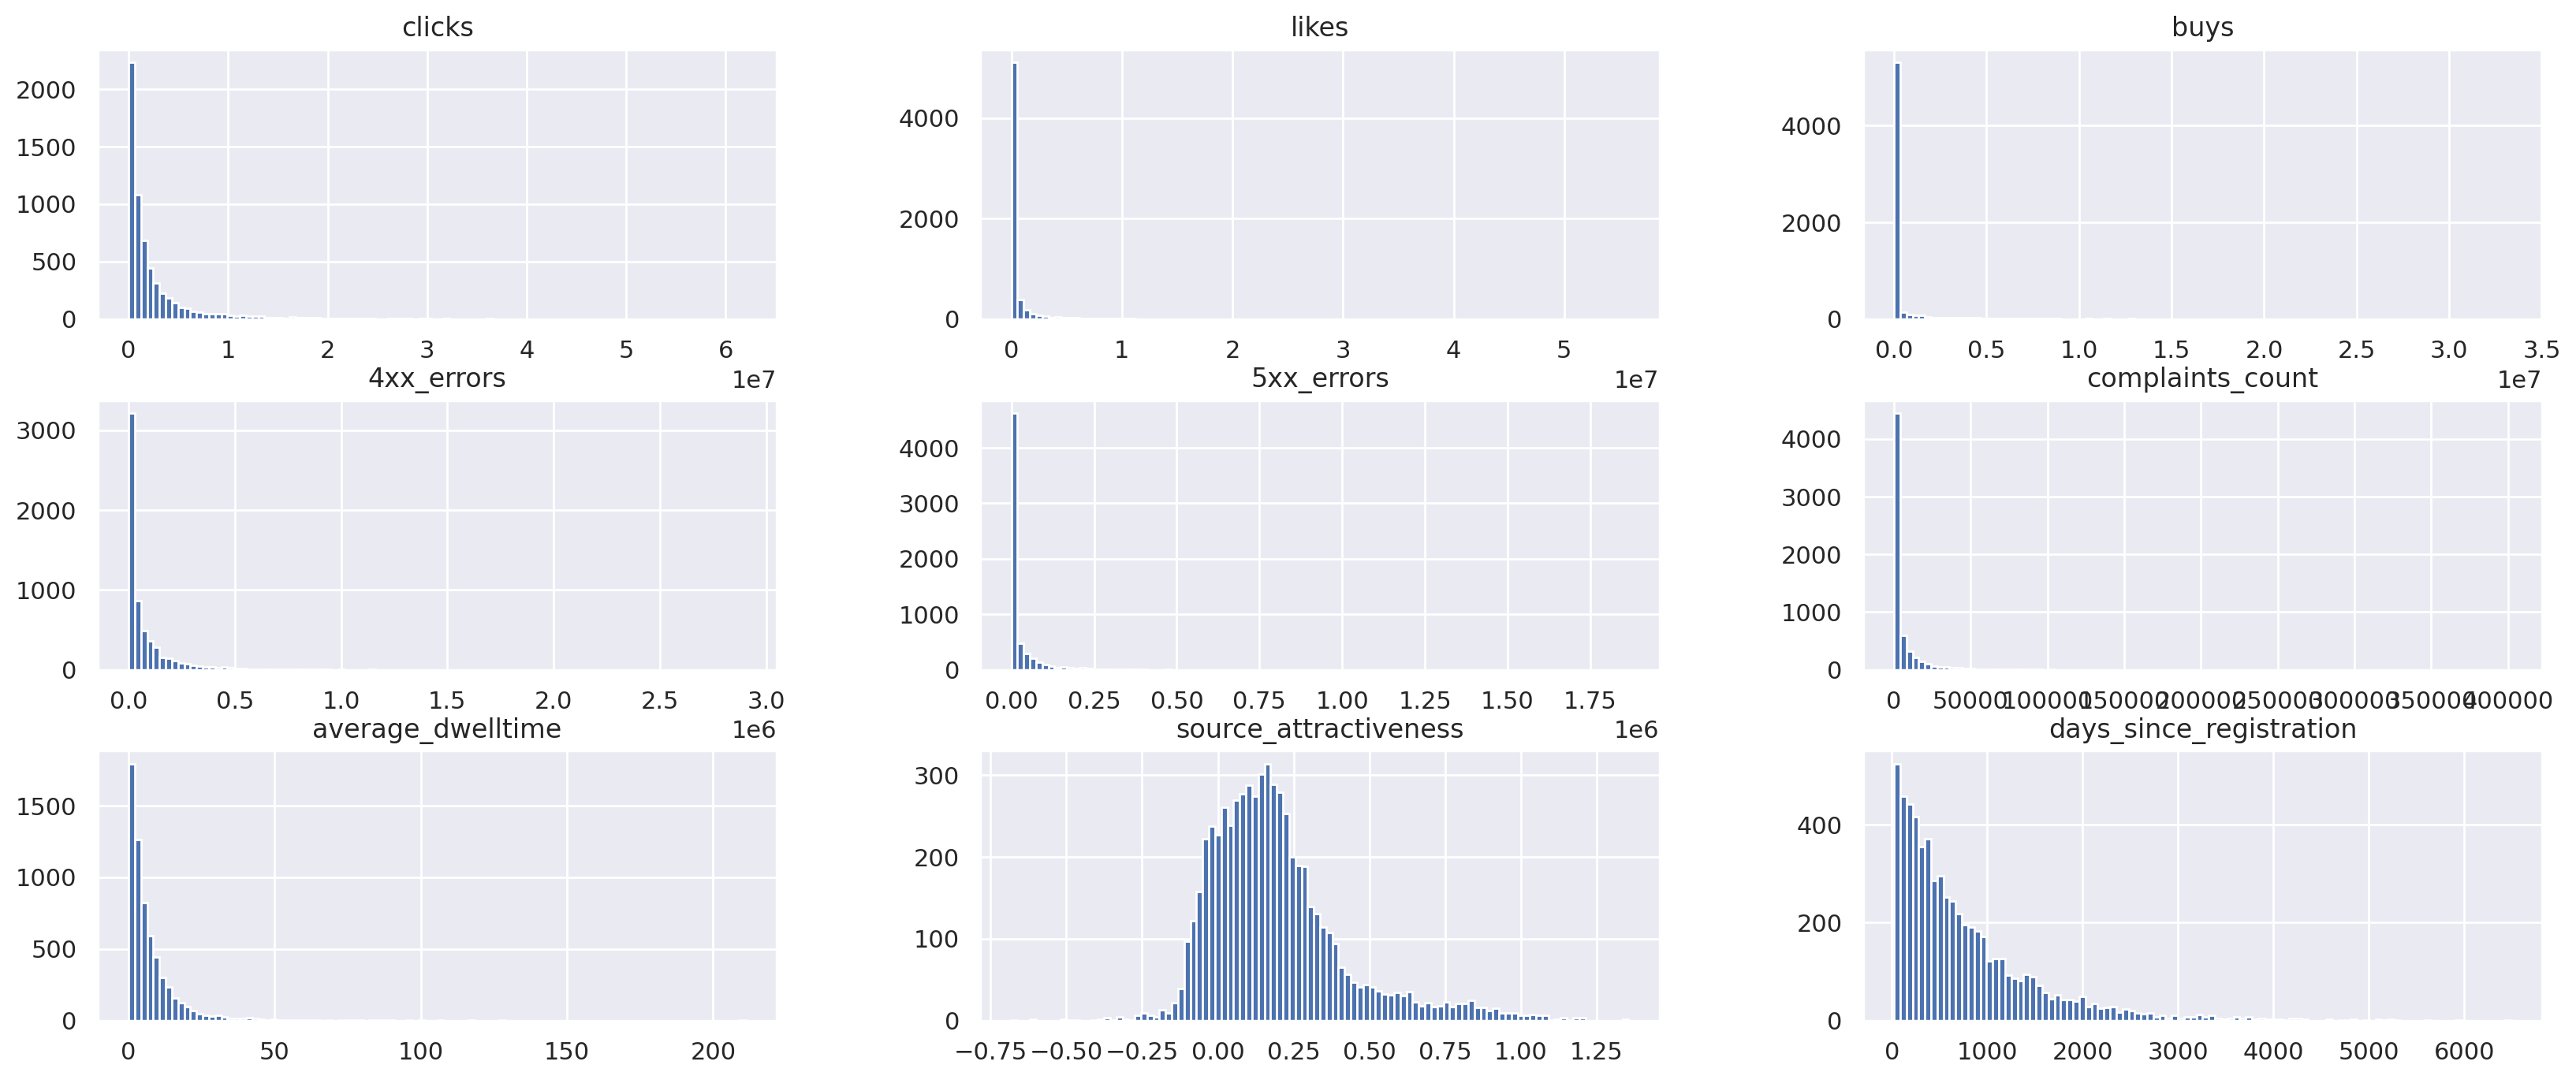

In [16]:
preprocess_data_time_cat(dataset).hist(bins=100, figsize=(20,8))

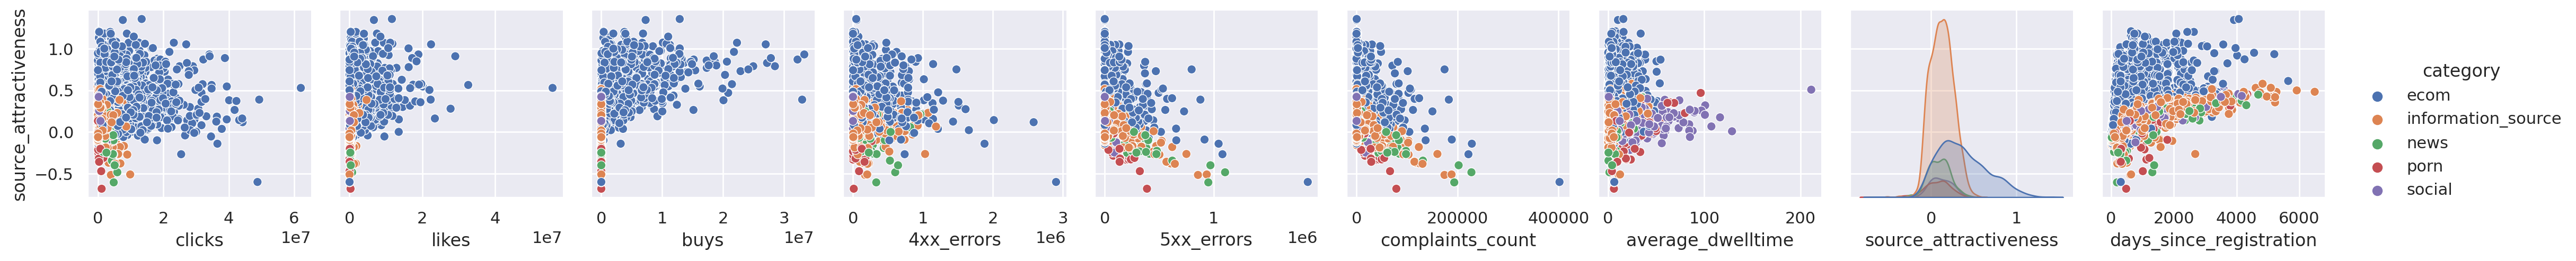

In [17]:
sns.pairplot(data=preprocess_data_time_cat(dataset), y_vars=['source_attractiveness'], hue='category')

<Axes: xlabel='buys', ylabel='Count'>

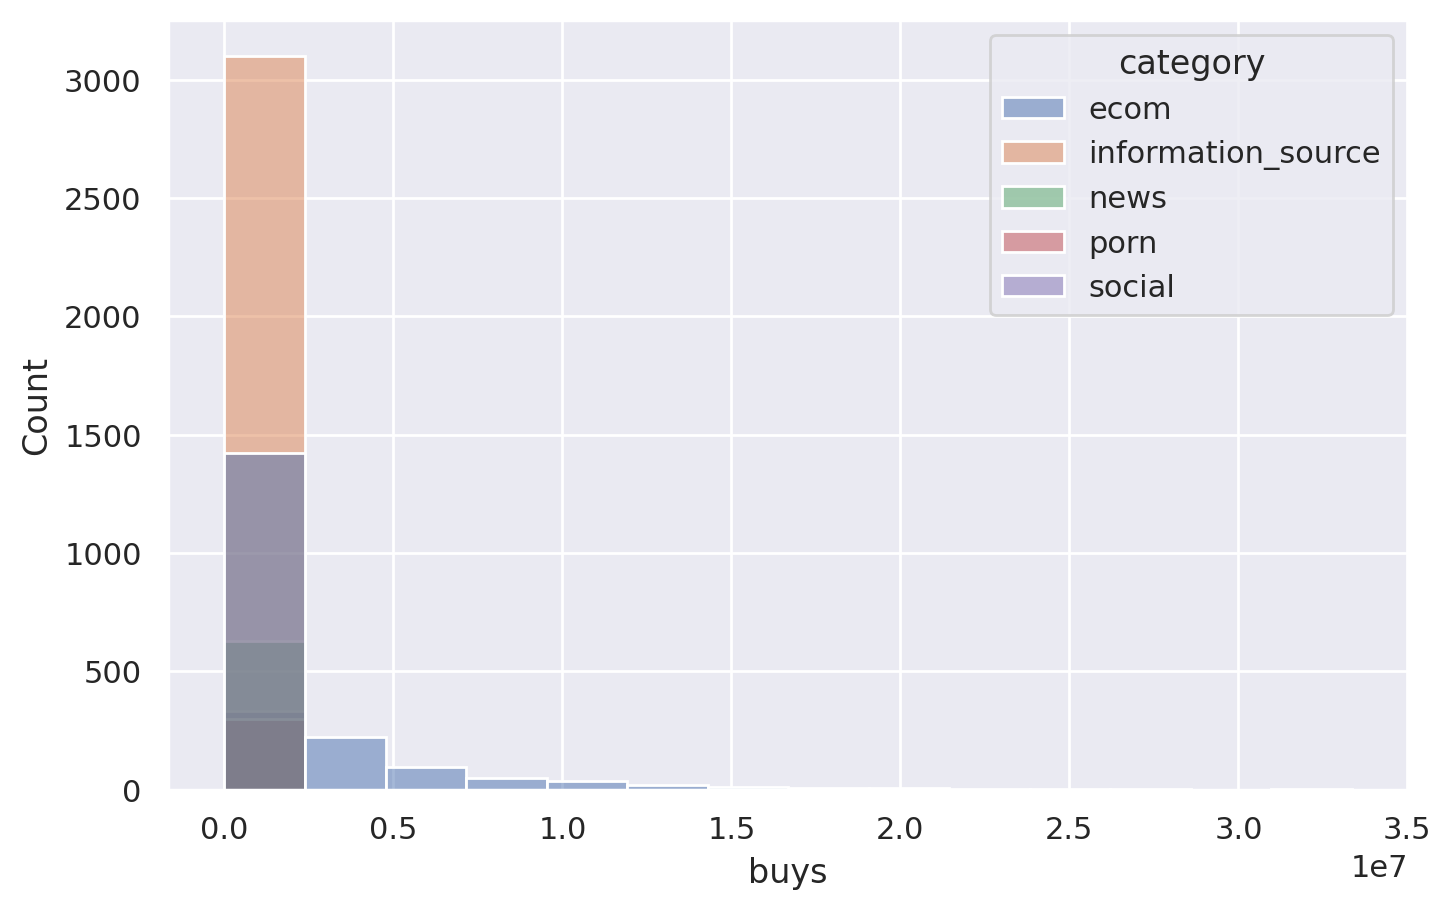

In [18]:
sns.histplot(data=preprocess_data_time_cat(dataset), x='buys', hue='category')

<Axes: >

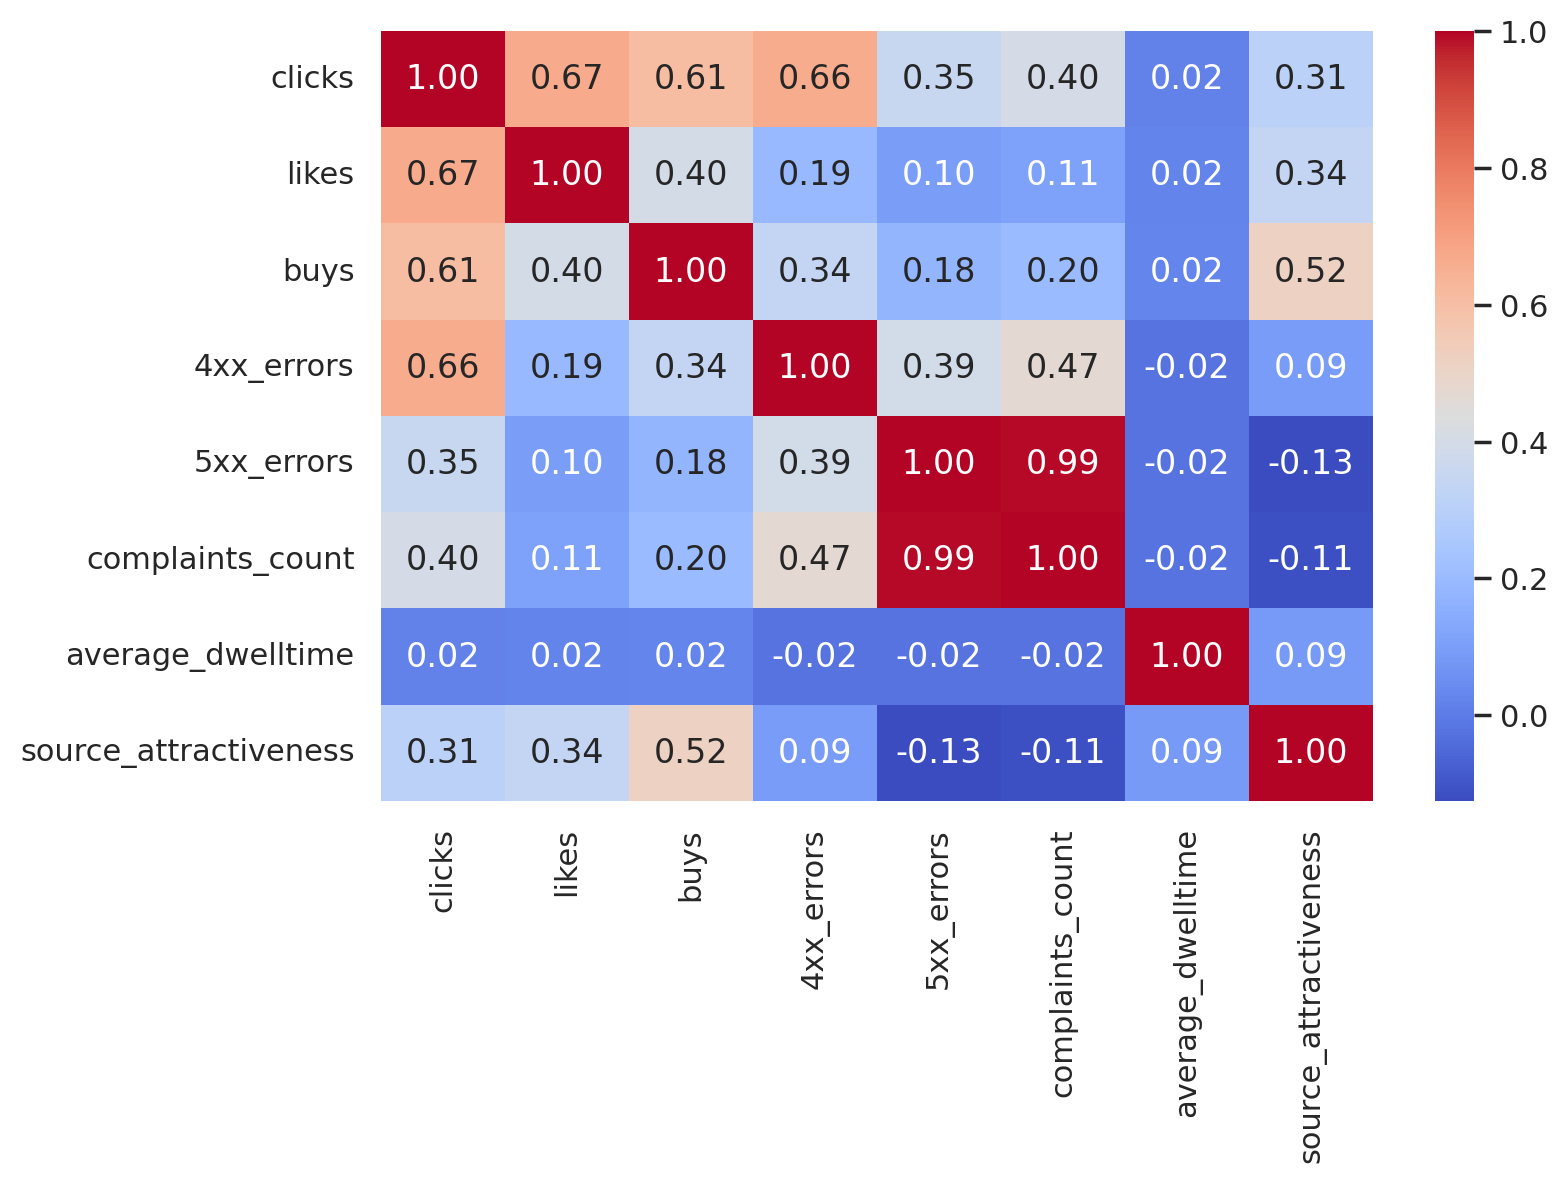

In [19]:
corr_matrix = dataset.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

Корреляционная матрица:
                       clicks   likes    buys  4xx_errors  5xx_errors  complaints_count  average_dwelltime  source_attractiveness
clicks                1.00000 0.66816 0.60837     0.66195     0.35204           0.39792            0.01565                0.30648
likes                 0.66816 1.00000 0.39709     0.19247     0.09888           0.11160            0.02408                0.34058
buys                  0.60837 0.39709 1.00000     0.33733     0.17555           0.19886            0.02430                0.52007
4xx_errors            0.66195 0.19247 0.33733     1.00000     0.39168           0.46864           -0.02193                0.09067
5xx_errors            0.35204 0.09888 0.17555     0.39168     1.00000           0.99494           -0.02042               -0.12522
complaints_count      0.39792 0.11160 0.19886     0.46864     0.99494           1.00000           -0.02148               -0.11370
average_dwelltime     0.01565 0.02408 0.02430    -0.02193    -0.02

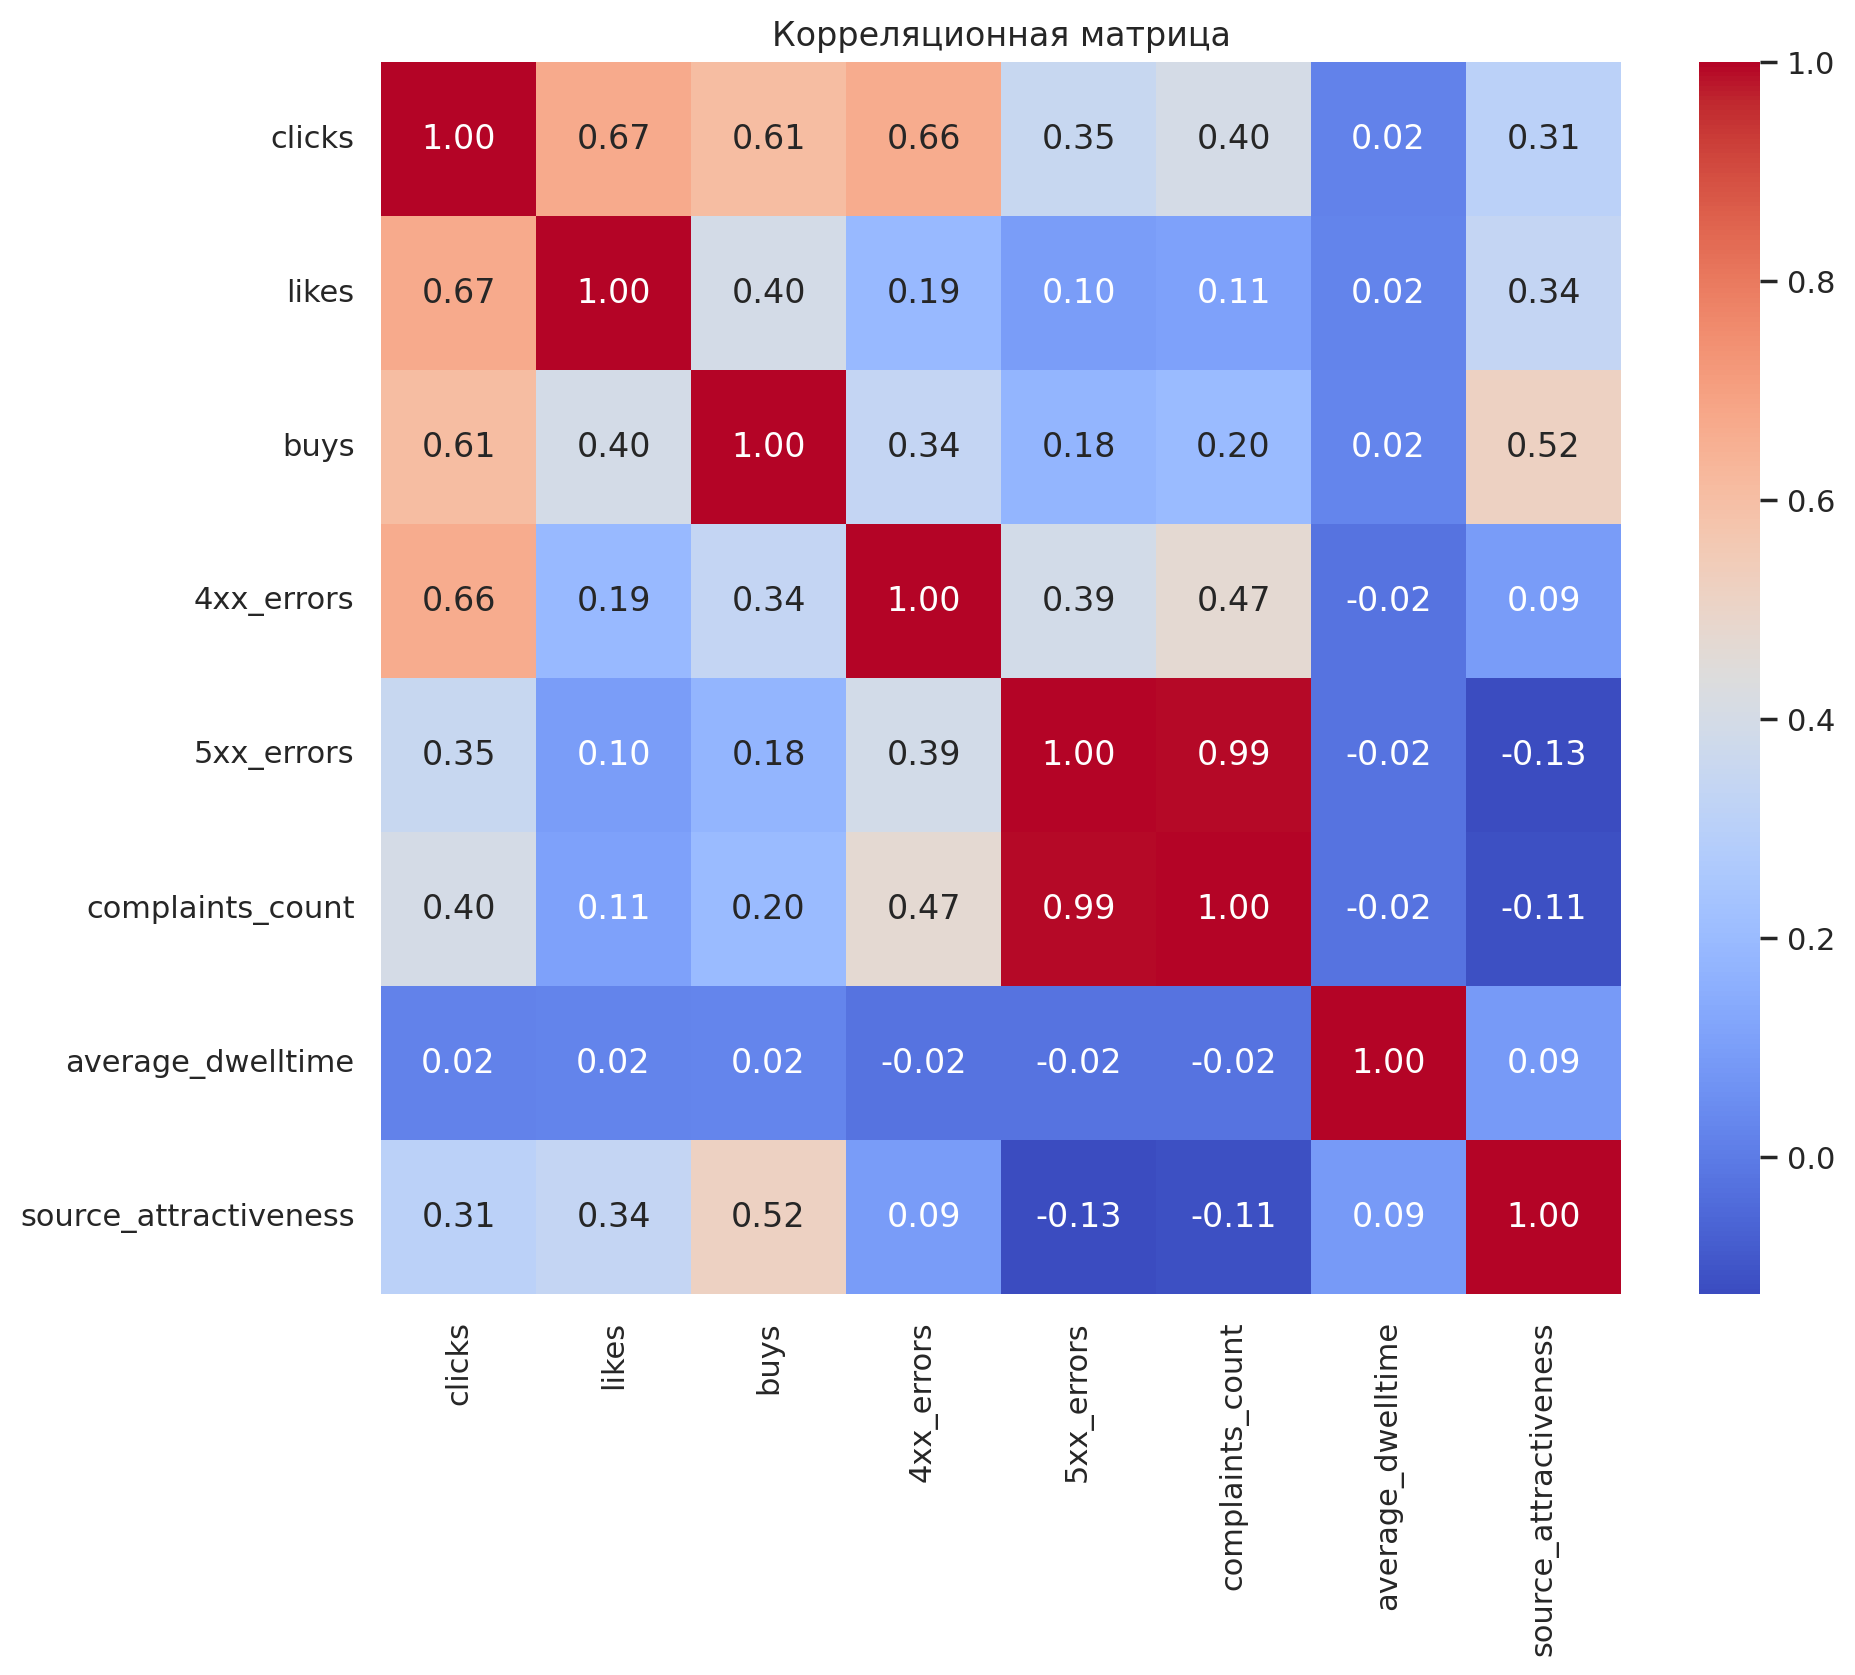

Новая корреляционная матрица после добавления признаков:
source_attractiveness                 1.00000
buys                                  0.52007
mean_by_group                         0.51866
likes                                 0.34058
clicks                                0.30648
4xx_errors                            0.09067
average_dwelltime                     0.08634
likes                                 0.03283
clicks                                0.02287
4xx_errors                            0.01801
likes^2                               0.01541
likes average_dwelltime               0.01482
buys                                  0.01198
likes buys                            0.01003
buys average_dwelltime                0.00942
clicks likes                          0.00876
clicks buys                           0.00465
likes 5xx_errors                      0.00390
likes complaints_count                0.00379
clicks^2                              0.00361
buys 5xx_errors        

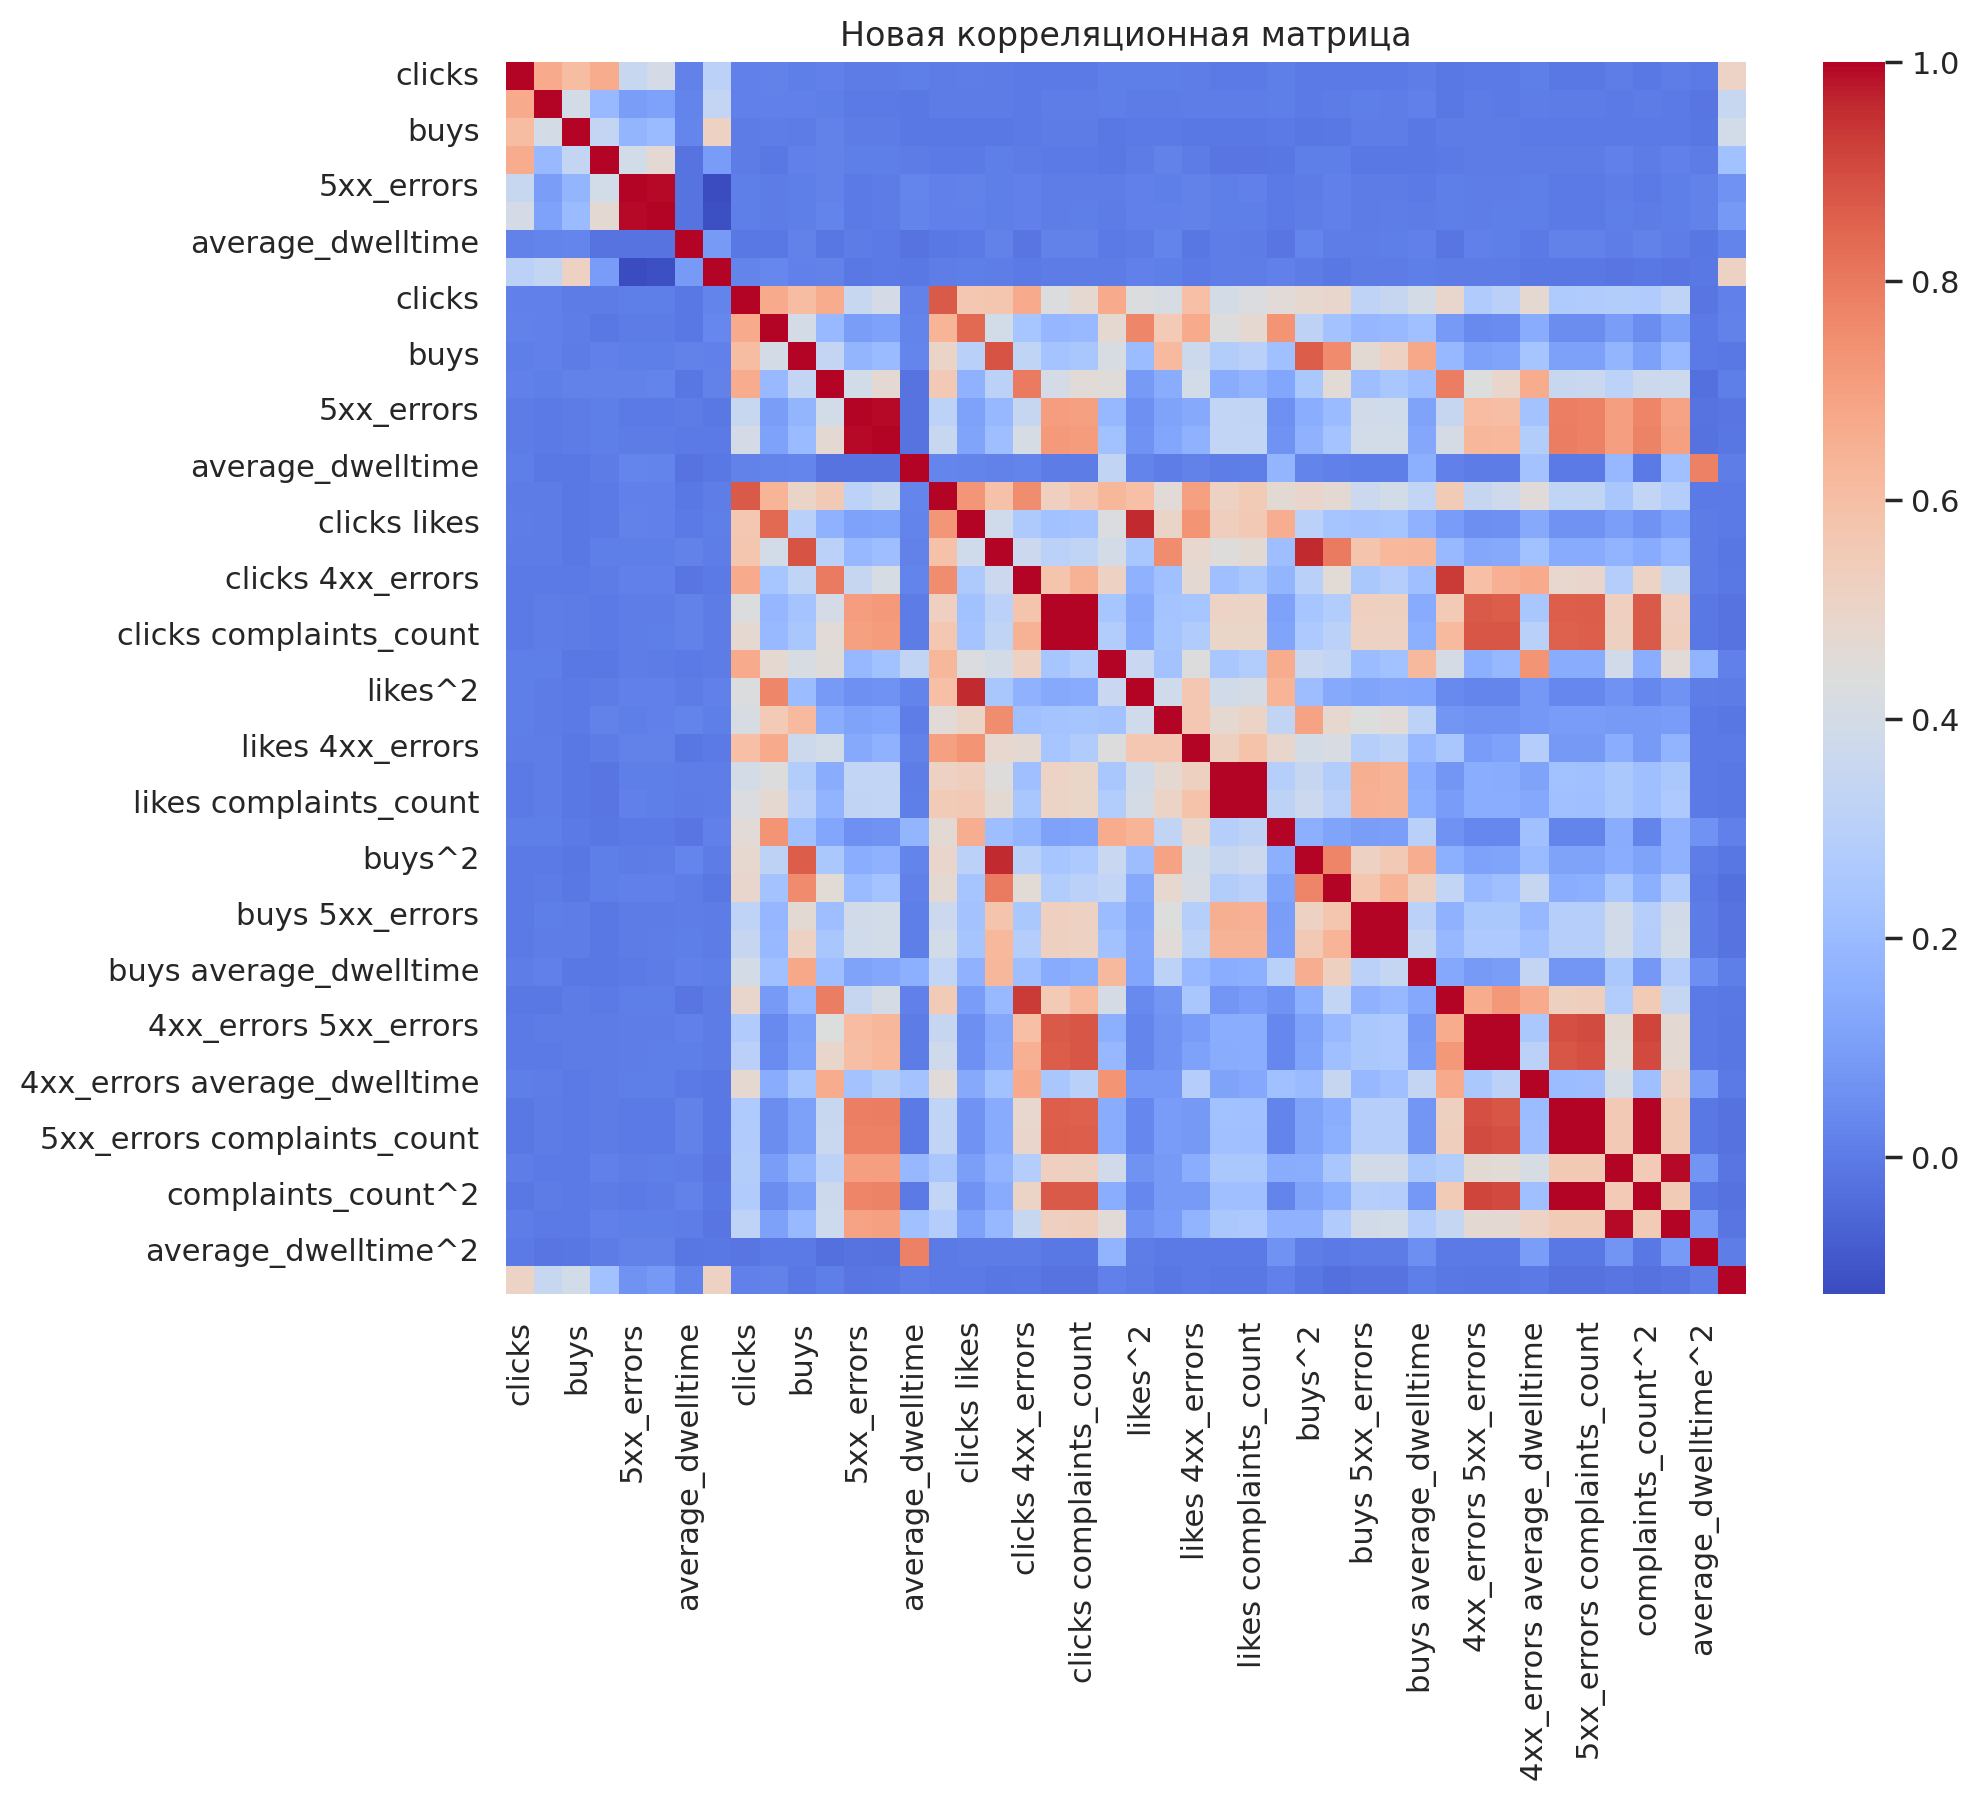

In [20]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Шаг 2: Проверка корреляции
print("Корреляционная матрица:")
corr_matrix = dataset.select_dtypes(include=[np.number]).corr()
print(corr_matrix)

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

# Шаг 3: Генерация новых признаков

# Полиномиальные признаки
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
numeric_columns = dataset.select_dtypes(include=[np.number]).columns.drop('source_attractiveness')
dataset_poly = pd.DataFrame(poly.fit_transform(dataset[numeric_columns]), columns=poly.get_feature_names_out(numeric_columns))

# Добавляем полиномиальные признаки к исходным данным
dataset_new = pd.concat([dataset, dataset_poly], axis=1)

# Признаки на основе групп
dataset_new['mean_by_group'] = dataset_new.groupby('category')['source_attractiveness'].transform('mean')  # среднее по группам

# Шаг 4: Проверка новой корреляции после создания признаков
new_corr_matrix = dataset_new.select_dtypes(include=[np.number]).corr()
print("Новая корреляционная матрица после добавления признаков:")
print(new_corr_matrix['source_attractiveness'].sort_values(ascending=False))

# Визуализация новой корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(new_corr_matrix, cmap='coolwarm', annot=False)
plt.title('Новая корреляционная матрица')
plt.show()

## Разделение на обучающую и тестовую выборки

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=[target]), dataset[target], test_size=0.2, random_state=42, stratify=dataset.category)

# preprocessor = FunctionTransformer(preprocess_data_time_cat)

# numeric_transformer = Pipeline(
#     steps=[
#         ("imputer", SimpleImputer(strategy="mean")), 
#         ("scaler", StandardScaler()),
#         ("poly", PolynomialFeatures(degree=2))
#         ]
# )
# columnTransformer = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, selector(dtype_exclude="category")),
#         ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist'), selector(dtype_include="category"))
#     ], n_jobs=-1)

# regressor = ElasticNet(alpha=0.00095, l1_ratio=0.33, max_iter=10000, warm_start=True, random_state=42)
# lr_pipeline = Pipeline(steps=[ 
#         ('preprocessor', preprocessor),
#         ('columnTransformer', columnTransformer),
#         ('regressor', regressor)
# ], verbose=False) 

# param_grid = {
#     'regressor__alpha': [1, 0.1, 0.001, 0.0001],
#     'regressor__l1_ratio': [1, 0.5, 0.33, 0.1, 0.01]   
# }

# grid_search = GridSearchCV(lr_pipeline, param_grid, cv=3, n_jobs=-1,
#                            scoring='neg_mean_squared_error', verbose=0, refit=True)

# grid_search.fit(X_train, y_train)
# y_pred = grid_search.predict(X_test)
# r2_score(y_test, y_pred)

In [22]:
# grid_search.best_params_

In [23]:
# mean_squared_error(y_test, y_pred)

In [24]:
# dataset_temp = dataset.copy()
# X_train, X_test, y_train, y_test = train_test_split(dataset_temp.drop(columns=[target]), dataset_temp[target], stratify=dataset_temp.category,test_size=0.2, random_state=42)

# preprocessor = FunctionTransformer(preprocess_data_time_cat)

# numeric_transformer = Pipeline(
#     steps=[
#         ("log", FunctionTransformer(np.log1p)),
#         ("imputer", SimpleImputer(strategy="mean")), 
#         ("scaler", StandardScaler()),
#         ("poly", PolynomialFeatures(degree=2))
#         ]
# )
# columnTransformer = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, selector(dtype_exclude="category")),
#         ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist'), selector(dtype_include="category"))
#     ], n_jobs=-1)

# regressor = ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=10000, warm_start=True, random_state=42)
# lr_pipeline = Pipeline(steps=[ 
#         ('preprocessor', preprocessor),
#         ('columnTransformer', columnTransformer),
#         ('regressor', regressor)
# ], verbose=False) 

# param_grid = {
#     'regressor__alpha': [0.1, 0.001],
#     'regressor__l1_ratio': [0, 0.1, 0.5, 1]
# }
# grid_search = GridSearchCV(lr_pipeline, param_grid, cv=5, n_jobs=-1,
#                            scoring='neg_mean_squared_error', verbose=0)


# grid_search.fit(X_train, y_train)
# y_pred = grid_search.predict(X_test)
# r2_score(y_test, y_pred)

In [25]:
# mean_squared_error(y_test, y_pred)

## Ensemble


In [26]:
df

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
6622,ecom,6488536.00000,NaN,0,82221,0,0,18.45053,0.46175,2020-04-21 16:04:41.817367072
2047,information_source,874840.00000,21100.00000,0,12872,0,0,10.72162,-0.02232,2024-07-19 23:50:07.268931816
1118,information_source,571210.00000,94707.00000,0,0,7420,0,1.92224,0.04640,2024-07-13 16:35:54.794883135
4992,news,89534.00000,924.00000,0,834,0,0,2.14924,-0.09336,2024-09-10 21:29:14.006315095
9970,information_source,1043953.00000,289288.00000,0,58375,20260,3948,3.76497,0.02730,2024-05-26 11:07:15.950527838
...,...,...,...,...,...,...,...,...,...,...
361,information_source,1468601.00000,474524.00000,0,61307,83928,16841,4.19148,0.01747,2023-06-20 19:48:01.783634440
2621,information_source,93172.00000,6418.00000,0,3418,705,0,3.74519,-0.01907,2024-07-22 08:45:41.700070757
2605,information_source,82916.00000,0.00000,0,4302,1718,1007,5.83748,-0.06152,2024-06-17 05:44:08.100200436
1231,social,823896.00000,105666.00000,0,0,2892,267,11.99404,0.13162,2023-06-11 02:53:14.377302808


In [27]:
def preprocess_data_time_ecom(df):
    data = df.copy()
    data.complaints_count = data.complaints_count.replace('-', np.NAN)
    data.average_dwelltime = data.average_dwelltime.replace(-1, np.NAN)
    data.complaints_count = data.complaints_count.astype(dtype="Int64")
    data.clicks = data.clicks.astype(dtype="Int64")
    data.date_of_registration = pd.to_datetime(data.date_of_registration)
    data.likes = data.likes.astype(dtype="Int64")
    data['clicks_per_like'] = data.clicks / (data.likes + 1)
    data['clicks_per_buy'] = data.clicks / (data.buys + 1)
    data['complaints_per_like'] = data.complaints_count / (data.likes + 1)
    data['complaints_per_buy'] = data.complaints_count / (data.buys + 1)
    data['errors_per_1000_clicks'] = (data['4xx_errors'] + data['5xx_errors'])/(data['clicks'] / 1000 + 1)  
    data['years_since_registration'] = (pd.to_datetime('now') - data['date_of_registration']).dt.days // 365
    data['years_since_registration_cat'] = ((pd.to_datetime('now') - data['date_of_registration']).dt.days // 365).astype(dtype="category")
    data['days_since_registration'] = (pd.to_datetime('now') - data['date_of_registration']).dt.days
    data['year'] =  data.date_of_registration.dt.year.astype(dtype="category")
    data['day_of_year'] =  data.date_of_registration.dt.dayofyear.astype(dtype="category")
    data.drop(columns='5xx_errors')
    data = data.drop(columns=['date_of_registration'])
    return data



def preprocess_data_time_other(df):
    data = df.copy()
    data.category = data.category.fillna('other')
    data.complaints_count = data.complaints_count.replace('-', np.NAN)
    data.average_dwelltime = data.average_dwelltime.replace(-1, np.NAN)
    data.category = data.category.astype(dtype="category")
    data.complaints_count = data.complaints_count.astype(dtype="Int64")
    data.clicks = data.clicks.astype(dtype="Int64")
    data.date_of_registration = pd.to_datetime(data.date_of_registration)
    data.likes = data.likes.astype(dtype="Int64")
    data['clicks_per_like'] = data.clicks / (data.likes + 1)
    data['errors_per_1000_clicks'] = (data['4xx_errors'] + data['5xx_errors'])/(data['clicks'] / 1000 + 1)  
    data['years_since_registration'] = (pd.to_datetime('now') - data['date_of_registration']).dt.days // 365
    data['years_since_registration_cat'] = ((pd.to_datetime('now') - data['date_of_registration']).dt.days // 365).astype(dtype="category")
    data['days_since_registration'] = (pd.to_datetime('now') - data['date_of_registration']).dt.days
    data['year'] =  data.date_of_registration.dt.year.astype(dtype="category")
    data['day_of_year'] =  data.date_of_registration.dt.dayofyear.astype(dtype="category")
    data.drop(columns='5xx_errors')
    data = data.drop(columns=['date_of_registration'])
    return data


In [28]:
# Создаем кастомный трансформер для выбора модели на основе категории
class CategoryModelSelector(BaseEstimator, TransformerMixin):
    def __init__(self, ecom_model, other_model):
        self.ecom_model = ecom_model
        self.other_model = other_model
        
    def fit(self, X, y):
        ecom_indices = X['category'] == 'ecom'
        other_indices = X['category'] != 'ecom'
        
        # Разделяем данные по категориям и обучаем соответствующие модели
        self.ecom_model.fit(X[ecom_indices].drop(columns=['category']), y[ecom_indices])
        self.other_model.fit(X[other_indices], y[other_indices])
        return self
    
    def predict(self, X):
        # Предсказываем на основе категории
        predictions = pd.Series(index=X.index, dtype=float)
        ecom_indices = X['category'] == 'ecom'
        other_indices = X['category'] != 'ecom'
        
        predictions[ecom_indices] = self.ecom_model.predict(X[ecom_indices].drop(columns=['category']))
        predictions[other_indices] = self.other_model.predict(X[other_indices])
        
        return predictions
 
    
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[target]), df[target], stratify=df.category,test_size=0.2, random_state=42)


numeric_transformer1 = Pipeline(
    steps=[
        ("log", FunctionTransformer(np.log1p)),
        ("imputer", SimpleImputer(strategy="mean")), 
        ("scaler", StandardScaler())
        ]
)

numeric_transformer2 = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")), 
        ("scaler", StandardScaler())
        ]
)

columnTransformer1 = ColumnTransformer(
    transformers=[
        ('num1', numeric_transformer1, selector(dtype_exclude="category")),
        ('num2', numeric_transformer2, selector(dtype_exclude="category")),
        ('cat', GLMMEncoder(handle_unknown='value'), selector(dtype_include="category"))
    ], n_jobs=-1)

columnTransformer2 = ColumnTransformer(
    transformers=[
        ('num1', numeric_transformer1, selector(dtype_exclude="category")),
        ('num2', numeric_transformer2, selector(dtype_exclude="category")),
        ('cat', GLMMEncoder(handle_unknown='value'), selector(dtype_include="category"))
    ], n_jobs=-1)

ecom_pipeline = Pipeline(steps=[ 
        ('preprocessor', FunctionTransformer(preprocess_data_time_ecom)),
        ('columnTransformer', columnTransformer1),
        ("poly", PolynomialFeatures(degree=2, include_bias=True)),
        ('regressor', ElasticNet(alpha=0.001, l1_ratio=0.2, max_iter=10000, warm_start=True, random_state=42))
], verbose=False) 

other_pipeline = Pipeline(steps=[ 
        ('preprocessor', FunctionTransformer(preprocess_data_time_other)),
        ('columnTransformer', columnTransformer2),
        ("poly", PolynomialFeatures(degree=2, include_bias=True)),
        ('regressor', ElasticNet(alpha=0.001, l1_ratio=0.2, max_iter=10000, warm_start=True, random_state=42))
], verbose=False) 


# Объединяем это в единую структуру
model_selector = CategoryModelSelector(ecom_pipeline, other_pipeline)

# Обучаем модель
model_selector.fit(X_train, y_train)


y_pred = model_selector.predict(X_test)
r2_score(y_test, y_pred)

0.9410312074446381

In [29]:
mean_squared_error(y_test, y_pred)

0.003357891570355891

## Outlier detection


In [30]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, random_state=0)


numeric_transformer1 = Pipeline(
    steps=[
        ("log", FunctionTransformer(np.log1p)),
        ("imputer", SimpleImputer(strategy="mean")), 
        ("scaler", StandardScaler())
        ]
)

numeric_transformer2 = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")), 
        ("scaler", StandardScaler())
        ]
)

columnTransformer1 = ColumnTransformer(
    transformers=[
        ('num1', numeric_transformer1, selector(dtype_exclude="category")),
        ('num2', numeric_transformer2, selector(dtype_exclude="category")),
        ('cat', GLMMEncoder(handle_unknown='value'), selector(dtype_include="category"))
    ], n_jobs=-1)

outlier_detection = Pipeline(steps=[ 
        ('preprocessor', FunctionTransformer(preprocess_data_time_other)),
        ('columnTransformer', columnTransformer1),
        ("poly", PolynomialFeatures(degree=2, include_bias=True)),
        ('clf', clf)
], verbose=False) 
# Обучаем модель
anomaly = outlier_detection.fit_predict(df.drop(columns=[target]), df[target])


In [31]:
df_without_outliers = df.copy()
df_without_outliers['anomaly'] = anomaly
df_without_outliers = df_without_outliers[df_without_outliers.anomaly == 1].drop(columns=['anomaly'])
df_without_outliers

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
6622,ecom,6488536.00000,NaN,0,82221,0,0,18.45053,0.46175,2020-04-21 16:04:41.817367072
2047,information_source,874840.00000,21100.00000,0,12872,0,0,10.72162,-0.02232,2024-07-19 23:50:07.268931816
1118,information_source,571210.00000,94707.00000,0,0,7420,0,1.92224,0.04640,2024-07-13 16:35:54.794883135
4992,news,89534.00000,924.00000,0,834,0,0,2.14924,-0.09336,2024-09-10 21:29:14.006315095
9970,information_source,1043953.00000,289288.00000,0,58375,20260,3948,3.76497,0.02730,2024-05-26 11:07:15.950527838
...,...,...,...,...,...,...,...,...,...,...
361,information_source,1468601.00000,474524.00000,0,61307,83928,16841,4.19148,0.01747,2023-06-20 19:48:01.783634440
2621,information_source,93172.00000,6418.00000,0,3418,705,0,3.74519,-0.01907,2024-07-22 08:45:41.700070757
2605,information_source,82916.00000,0.00000,0,4302,1718,1007,5.83748,-0.06152,2024-06-17 05:44:08.100200436
1231,social,823896.00000,105666.00000,0,0,2892,267,11.99404,0.13162,2023-06-11 02:53:14.377302808


## Final model submit function

Принимает на вход путь к набору данных в формате `.csv`

На выходе получается файл с предиктами в формате `.csv`

Пример содержания:
```
0.432
0.412
0.312
```

Реализация модели - между ними

In [32]:
ecom_pipeline = Pipeline(steps=[ 
        ('preprocessor', FunctionTransformer(preprocess_data_time_ecom)),
        ('columnTransformer', columnTransformer1),
        ("poly", PolynomialFeatures(degree=2, include_bias=True)),
        ('regressor', ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=10000, warm_start=True, random_state=42))
], verbose=False) 

other_pipeline = Pipeline(steps=[ 
        ('preprocessor', FunctionTransformer(preprocess_data_time_other)),
        ('columnTransformer', columnTransformer2),
        ("poly", PolynomialFeatures(degree=2, include_bias=True)),
        ('regressor', ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=10000, warm_start=True, random_state=42))
], verbose=False) 


model_selector = CategoryModelSelector(ecom_pipeline, other_pipeline)
model_selector.fit(df.drop(columns=[target]), df[target])

CategoryModelSelector(ecom_model=Pipeline(steps=[('preprocessor',
                                                  FunctionTransformer(func=<function preprocess_data_time_ecom at 0x79ef91811fc0>)),
                                                 ('columnTransformer',
                                                  ColumnTransformer(n_jobs=-1,
                                                                    transformers=[('num1',
                                                                                   Pipeline(steps=[('log',
                                                                                                    FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                   ('imputer',
                                                                                                    SimpleImputer()),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   <sklearn.com...
                                                                                                     SimpleImputer()),
                                                                                                    ('scaler',
                                                                                                     StandardScaler())]),
                                                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x79ef91979300>),
                                                                                   ('cat',
                                                                                    GLMMEncoder(),
                                                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x79ef91979540>)])),
                                                  ('poly',
                                                   PolynomialFeatures()),
                                                  ('regressor',
                                                   ElasticNet(alpha=0.001,
                                                              l1_ratio=0.1,
                                                              max_iter=10000,
                                                              random_state=42,
                                                              warm_start=True))]))

In [33]:
test = pd.read_csv('../input/mai-ml-lab-1-biro/test.csv', index_col=0)

In [34]:
data = {
    "source_attractiveness": model_selector.predict(test)
}
submit = pd.DataFrame(data)
submit.to_csv('submission.csv', index_label="ID")
submit

,source_attractiveness
ID,
0,0.61357
1,0.03267
2,0.63923
3,0.54091
4,0.31394
...,...
1995,0.33535
1996,0.47149
1997,-0.01158
